In [1]:
import os
import torch
import joblib
import netCDF4

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.utils.data as data

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, Subset, TensorDataset

In [6]:
# Define input and output path
input_path = r"D:\GREAT\machine_learning\data\Rongowai\20221026-100450_NZRO-NZAA_L1.nc"
output_path = "geo-k-compression_model"

### Geo-K example

Do not run as it requires ready-to-use test.csv file and xarray library.

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load metadata CSV
metadata = pd.read_csv("/test.csv")  # csv path to select data from netcdf file

# Load and flatten DDMs
ddm_list = []
for i, row in metadata.iterrows():
    file_path = os.path.join(input_path, "RONGOWAI_L1_SDR_V1.0_1.0-20250328_225352", row["File Name"])  # dataset path
    sample_idx = int(row["Sample Index"])
    ddm_idx = int(row["DDM Index"])

    try:
        ds = xr.open_dataset(file_path)
        ddm = ds["L1a_power_ddm"].isel(sample=sample_idx, ddm=ddm_idx).values
        ds.close()

        if ddm.shape != (40, 5):
            continue

        ddm_flat = ddm.flatten()  # Shape (200,)
        ddm_list.append(ddm_flat)

    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        continue

# Normalization and conversion to tensor
ddm_data_raw = np.stack(ddm_list)

# Normalize to [0, 1]
scaler = MinMaxScaler()
ddm_data = scaler.fit_transform(ddm_data_raw * 1e13)
joblib.dump(scaler, os.path.join(output_path, "scaler_encoder2.pkl"))

# Convert to tensor
tensor_data = torch.tensor(ddm_data, dtype=torch.float32)
test_dataset = TensorDataset(tensor_data)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Test size: {len(test_dataset)}")

In [ ]:
#AUTOENCODER DEFINITION

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# Define model architecture
# ----------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, 200)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------
# Load the saved models
# ----------------------
def load_model(model_class, path):
    model = model_class().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

encoder = load_model(Encoder, os.path.join(input_path, "encoder_all_surface2.pth"))
decoder = load_model(Decoder, os.path.join(input_path, "decoder_all_surface2.pth"))

# ----------------------
# Load test data
# ----------------------
# Get 1 batch from test set for visualization
test_batch, = next(iter(test_loader))
test_batch = test_batch.to(device)

# ----------------------
# Perform inference
# ----------------------
with torch.no_grad():
    encoded = encoder(test_batch)
    reconstructed = decoder(encoded)

In [ ]:
# ----------------------
# Denormalize (optional)
# ----------------------
# If using a scaler to inverse transform
scaler = joblib.load(os.path.join(output_path, "scaler_encoder2.pkl"))
test_batch_np = test_batch.cpu().numpy()
reconstructed_np = reconstructed.cpu().numpy()

# Denormalize to original scale
test_batch_denorm = scaler.inverse_transform(test_batch_np) / 1e13
reconstructed_denorm = scaler.inverse_transform(reconstructed_np) / 1e13

# ----------------------
# Plot Original vs Reconstructed
# ----------------------
num_samples_to_visualize = 10
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original Sample {i}")
    plt.plot(test_batch_denorm[i], label="Original")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"Reconstructed Sample {i}")
    plt.plot(reconstructed_denorm[i], label="Reconstructed")
    plt.legend()

    plt.show()

### aizoOn example

Run this to work with netCDF and netCDF4 library as usual.

In [29]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load and flatten DDMs
file_path = os.path.join(input_path)  # dataset path
ddm_list = list()

ds = netCDF4.Dataset(file_path)
ddm = ds["L1a_power_ddm"][:] # Shape (N, 40, 5)
print(ddm.shape)
ds.close()

for sample in tqdm(range(ddm.shape[0])):
    for channel in range(ddm.shape[1]):
        ddm_sample = ddm[sample, channel].reshape(200,) # Shape (200,)
        if max(ddm_sample) > 0 : ddm_list.append(ddm_sample)

# Normalization and conversion to tensor
ddm_data_raw = np.stack(ddm_list)
print(ddm_data_raw.shape)

# Normalize to [0, 1]
scaler = MinMaxScaler()
ddm_data = scaler.fit_transform(ddm_data_raw * 1e13)
joblib.dump(scaler, os.path.join(output_path, "scaler_encoder2.pkl"))

# Convert to tensor
tensor_data = torch.tensor(ddm_data, dtype=torch.float32)
test_dataset = TensorDataset(tensor_data)

# Create DataLoaders
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Test size: {len(test_dataset)}")

(1539, 20, 40, 5)


100%|██████████| 1539/1539 [00:16<00:00, 91.95it/s]


(29652, 200)
Test size: 29652


In [31]:
#AUTOENCODER DEFINITION

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------
# Define model architecture
# ----------------------
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(20, 100),
            nn.ReLU(),
            nn.Linear(100, 200)
        )

    def forward(self, x):
        return self.net(x)

# ----------------------
# Load the saved models
# ----------------------
def load_model(model_class, path):
    model = model_class().to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    return model

encoder = load_model(Encoder, os.path.join(r"geo-k-compression_model\encoder_all_surface2.pth"))
decoder = load_model(Decoder, os.path.join(r"geo-k-compression_model\decoder_all_surface2.pth"))

# ----------------------
# Load test data
# ----------------------
# Get 1 batch from test set for visualization
test_batch, = next(iter(test_loader))
test_batch = test_batch.to(device)

# ----------------------
# Perform inference
# ----------------------
with torch.no_grad():
    encoded = encoder(test_batch)
    reconstructed = decoder(encoded)

In [34]:
test_batch.shape, encoded.shape, reconstructed.shape

(torch.Size([32, 200]), torch.Size([32, 20]), torch.Size([32, 200]))

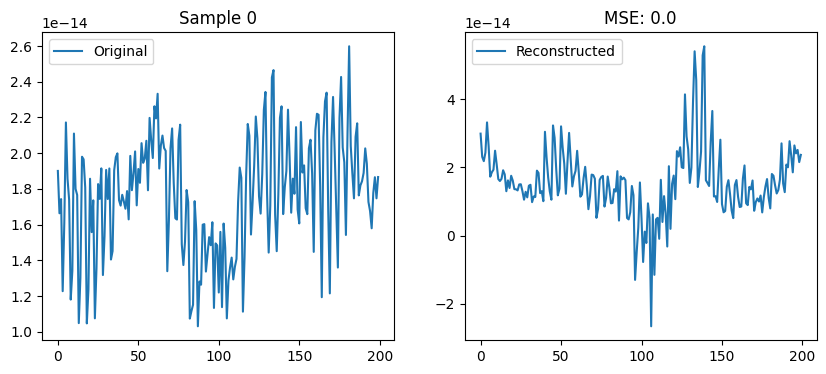

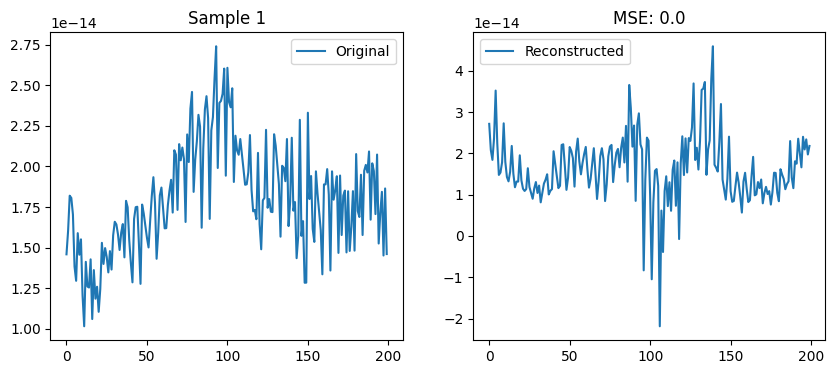

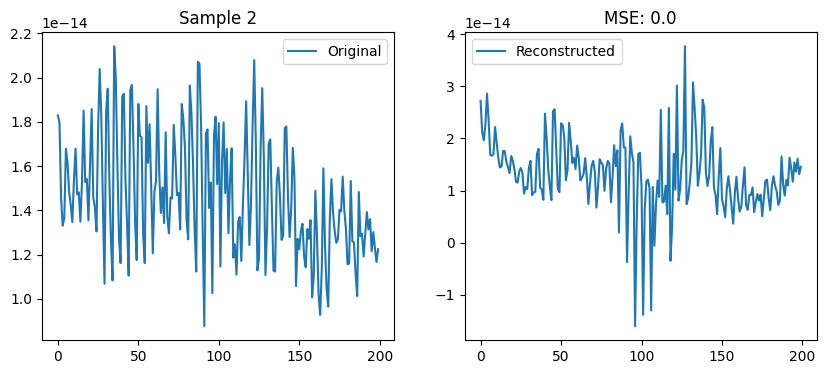

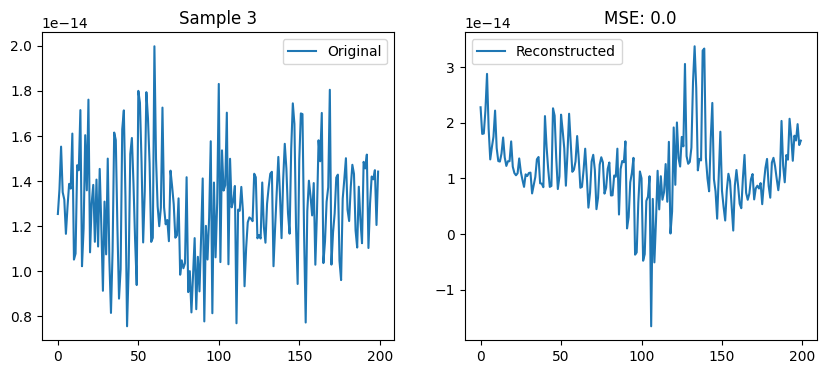

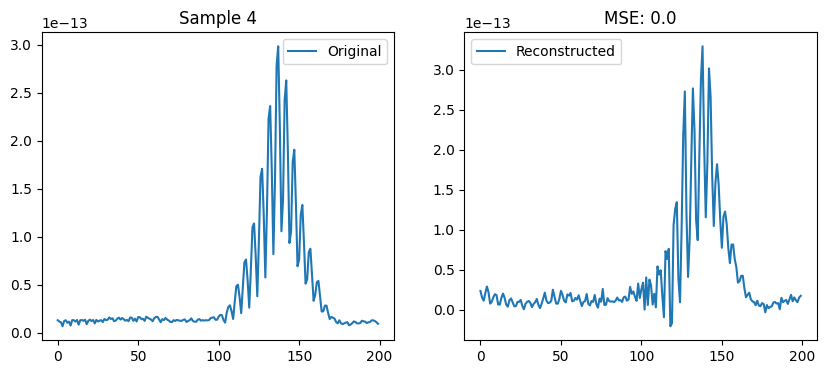

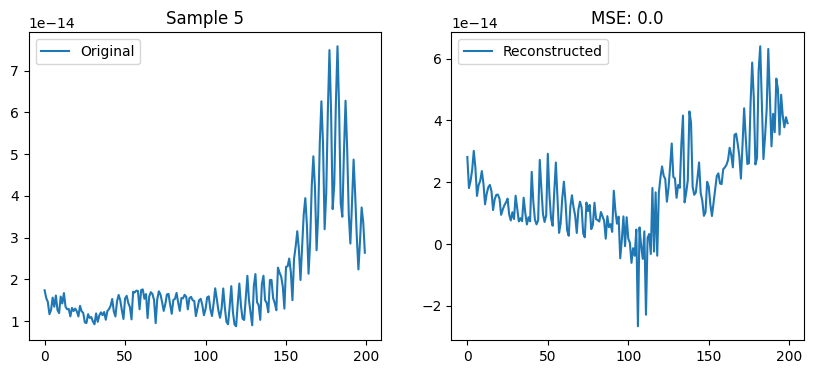

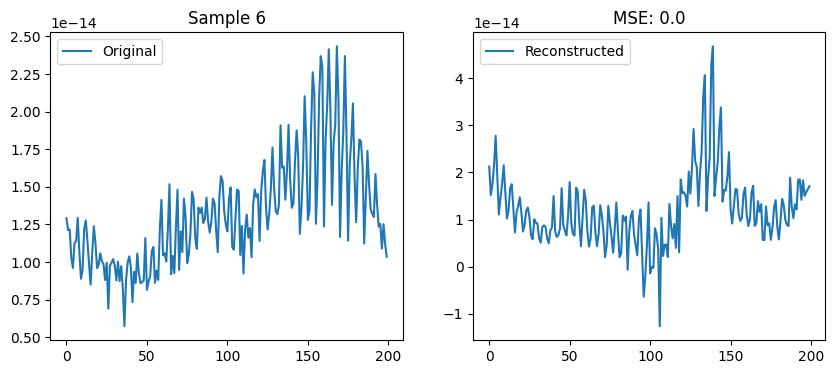

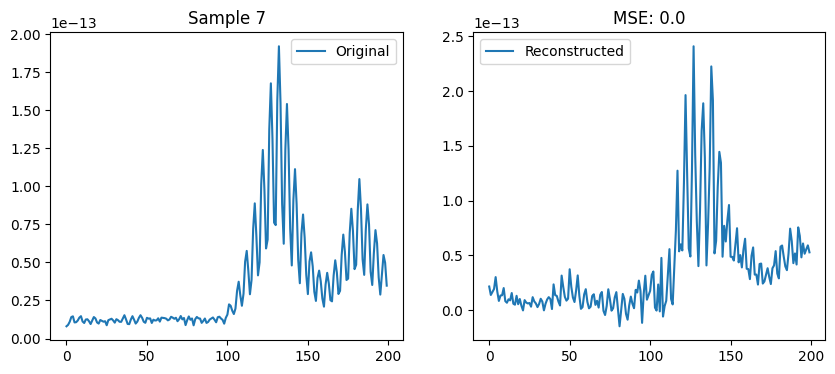

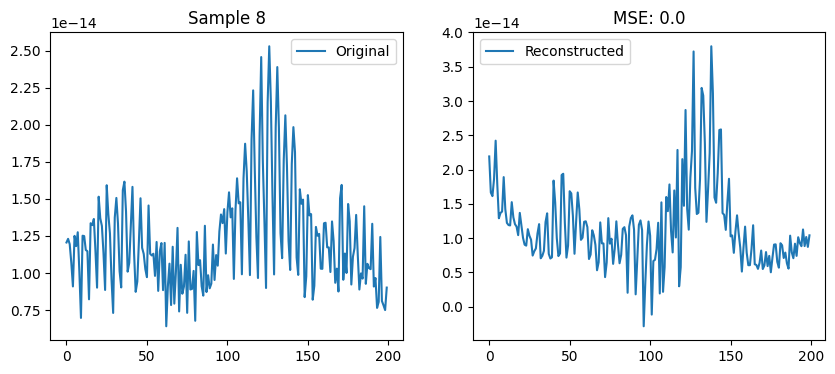

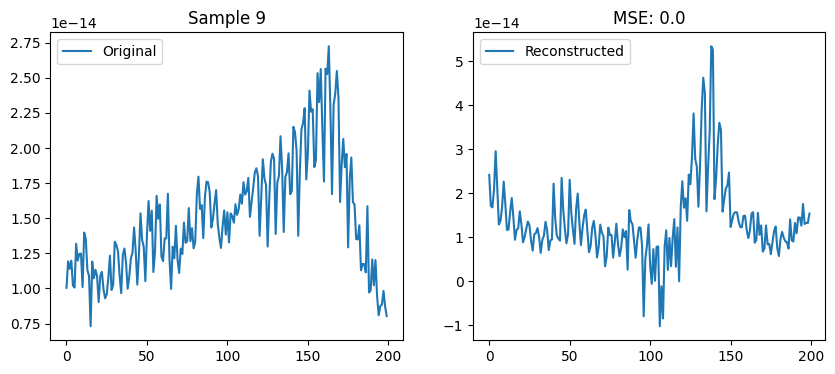

In [41]:
# ----------------------
# Denormalize (optional)
# ----------------------
# If using a scaler to inverse transform
scaler = joblib.load(os.path.join(output_path, "scaler_encoder2.pkl"))
test_batch_np = test_batch.cpu().numpy()
reconstructed_np = reconstructed.cpu().numpy()

# Denormalize to original scale
test_batch_denorm = scaler.inverse_transform(test_batch_np) / 1e13
reconstructed_denorm = scaler.inverse_transform(reconstructed_np) / 1e13

# ----------------------
# Plot Original vs Reconstructed
# ----------------------
num_samples_to_visualize = 10
for i in range(num_samples_to_visualize):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Sample {i}")
    plt.plot(test_batch_denorm[i], label="Original")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.title(f"MSE: {np.round(np.mean((test_batch_denorm[i] - reconstructed_denorm[i])**2), 3)}")
    plt.plot(reconstructed_denorm[i], label="Reconstructed")
    plt.legend()

    plt.show()